In [1]:
import cupy as cp
import matplotlib.pyplot as plt
from functions import R,RT,mshow_complex,mshow
from phantom import *

import cupyx.scipy.ndimage as ndimage

# load object, the object should be complex64

In [ ]:
scale = 1
shape = (scale*64, scale*64)
centers = np.array([
    (scale*32, scale*32),  # Center of first circle
    (scale*24, scale*36),  # Center of second circle
    (scale*42, scale*24),  # Center of third circle
])
radii = np.array([
    scale*24,  # Radius of first circle
    scale*10,  # Radius of second circle
    scale*5,   # Radius of third circle
])
# domains = np.array([
#     [1.0, 0.0],   # Direction of first circle
#     [0.0, -1.0],   # Direction of second circle
#     [-1.0, 1.0],   # Direction of third circle
# ])

sphi = np.pi/6+np.pi/2
domains = np.array([
    [np.cos(sphi),np.sin(sphi)],   # Direction of first circle
    [-np.cos(sphi),-np.sin(sphi)],   # Direction of first circle
    [-np.cos(sphi),-np.sin(sphi)],   # Direction of first circle
])

 
# Create the phantom
field, mask = create_vector_field_phantom(
    shape, centers, radii, domains, transition_width=scale*1.0)

w=cp.tile(field,(1,1,1,1)).astype('float32')
mshow_complex(w[w.shape[0]//2,:,:,0]+1j*w[w.shape[0]//2,:,:,1])
# plt.quiver(x[0,:,:,0].get(),x[0,:,:,1].get())
plt.show()


## tomography pars
theta = cp.linspace(0,cp.pi,60,endpoint=True).astype('float32')
rotation_axis = w.shape[1]/2

mshow(np.linalg.norm(w[0],axis=-1),True)


(1, 150, 160) (1, 160, 160, 2)
0 err=1083.2686767578125
8 err=0.4780401289463043
16 err=0.38232794404029846


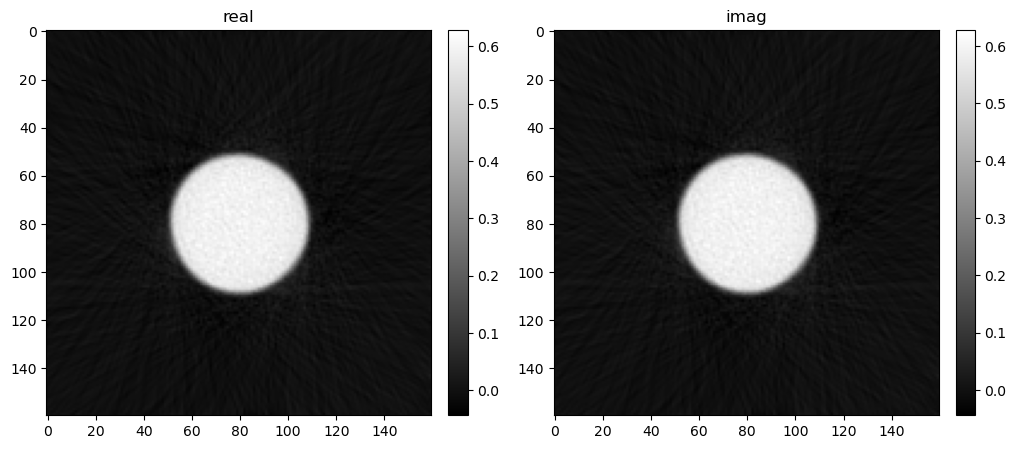

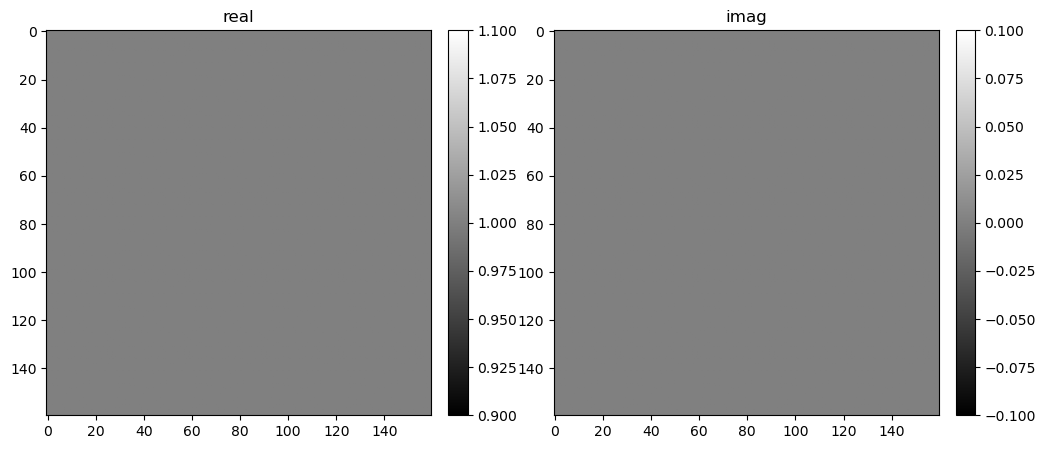

In [ ]:
rotation_axis = w.shape[1]/2

def F1(x):
    xc = x[:,:,:,0]+1j*x[:,:,:,1]
    Rx =  R(xc,theta,rotation_axis)
    Fx = Rx.real+Rx.imag
    return Fx
   
def F1adj(Fx):
    Rx = Fx+1j*Fx
    xc = RT(Rx,theta,rotation_axis)
    x = cp.zeros([*xc.shape,2],dtype='float32')
    x[...,0] = xc.real
    x[...,1] = xc.imag
    return x

def gradient(vars,d):
    w = vars['w']

    # first part
    gw = 2*F1adj(F1(w)-d) 
    
    # result
    grads = {}
    grads['w'] = gw
    return grads

def hessian_F1(vars,grads,etas):
    dw1 = grads['w']
    dw2 = etas['w']
    
    F1y = F1(dw1)
    F1z = F1(dw2)     
    t1 = 2*cp.real(cp.sum(F1y*cp.conj(F1z)))  
    return t1

def hessian(vars,grads,etas):
    return hessian_F1(vars,grads,etas)

def calc_err(vars,d):
    w = vars['w']
    return cp.linalg.norm(F1(w)-d)**2

def BH(vars, d, niter):
    err = cp.zeros(niter)
    for i in range(niter):
        
        if i%8==0:
            err[i] = calc_err(vars,d)
            print(i,f'err={err[i]}')
        grads = gradient(vars,d)
        
        if i == 0:
            etas = {}
            etas['w'] = -grads['w']
        else:
            top = hessian(vars,grads,etas)
            bottom = hessian(vars,etas,etas)
            beta = top / bottom
            etas['w'] = etas['w'] * beta - grads['w']
            
        top = -cp.sum(grads['w']*cp.conj(etas['w'])).real
        bottom = hessian(vars, etas, etas)
        alpha = top / bottom
        # if i%8==0:
        #     plot_debug(vars,etas,top,bottom,alpha,d,lam)

        vars['w'] += alpha * etas['w']        
    return vars,err

data = F1(w)
# data = data+0.2*(cp.random.random(data.shape)-0.5).astype('float32')
mshow(data[w.shape[0]//2].get())

# initial guess
vars = {}
vars['w'] = w*0
niter = 17
vars,err2 = BH(vars,data,niter)

mshow_complex(vars['w'][0,:,:,0]+1j*vars['w'][0,:,:,1])
mask = (vars['w'][...,0]>0.3).astype('float32')
mask[:]=1
mshow_complex(mask[0,:,:])

In [3]:
theta = (cp.load('tovictor/ang1.npy').astype('float32'))[:]#cp.linspace(0,cp.pi,60,endpoint=True).astype('float32')
rotation_axis = 80#w.shape[1]/2
data = (cp.load('tovictor/prj1diff.npy').astype('float32'))[:,80:81,:160].swapaxes(0,1)

w = cp.zeros([data.shape[0],data.shape[2],data.shape[2],2],dtype='float32')

# data-=cp.mean(data[data.shape[0]//2,:,:16])
print(theta)



[0.         0.06981317 0.13962634 0.20943952 0.27925268 0.34906584
 0.41887903 0.4886922  0.55850536 0.62831855 0.6981317  0.7679449
 0.83775806 0.9075712  0.9773844  1.0471976  1.1170107  1.1868238
 1.2566371  1.3264502  1.3962634  1.4660766  1.5358897  1.6057029
 1.6755161  1.7453293  1.8151424  1.8849556  1.9547688  2.024582
 2.0943952  2.1642082  2.2340214  2.3038347  2.3736477  2.443461
 2.5132742  2.5830872  2.6529005  2.7227137  2.7925267  2.86234
 2.9321532  3.0019662  3.0717795  3.1939526  3.2637658  3.3335788
 3.403392   3.4732053  3.5430183  3.6128316  3.6826446  3.7524579
 3.822271   3.8920841  3.9618974  4.0317106  4.101524   4.171337
 4.24115    4.310963   4.3807764  4.4505897  4.520403   4.590216
 4.660029   4.729842   4.7996554  4.8694687  4.939282   5.0090947
 5.078908   5.148721   5.2185345  5.2883477  5.358161   5.4279737
 5.497787   5.5676003  5.6374135  5.7072268  5.77704    5.846853
 5.916666   5.9864793  6.0562925  6.126106   6.195919   6.265732
 0.03490658 0.104

# Make operators

In [4]:

def F1(x):
    x*=mask[...,cp.newaxis]
    xc = x[:,:,:,0]+1j*x[:,:,:,1]    
    Rx =  R(xc,theta,rotation_axis)
    wc = -cp.cos(theta)[:,cp.newaxis]
    ws = -cp.sin(theta)[:,cp.newaxis]
    Fx = Rx.real*ws+Rx.imag*wc
    return Fx
   
def F1adj(Fx):
    wc = -cp.cos(theta)[:,cp.newaxis]
    ws = -cp.sin(theta)[:,cp.newaxis]
    Rx = Fx*ws+1j*Fx*wc
    xc = RT(Rx,theta,rotation_axis)
    x = cp.zeros([*xc.shape,2],dtype='float32')
    x[...,0] = xc.real
    x[...,1] = xc.imag
    x*=mask[...,cp.newaxis]
    return x

def F2(x):
    w,phi = x
    ax=w[...,0]*cp.cos(phi)+w[...,1]*cp.sin(phi)
    return ax*mask

def dF2(x,dx):
    w,phi = x
    dw1,dphi1 = dx
    t1 = cp.cos(phi)*dw1[...,0]
    t2 = cp.sin(phi)*dw1[...,1]
    t3 = (-cp.sin(phi)*w[...,0]+cp.cos(phi)*w[...,1])*dphi1
    return (t1+t2+t3)*mask

def d2F2(x,dx,dy):
    w,phi = x
    dw1,dphi1 = dx
    dw2,dphi2 = dy
    t1 = -cp.sin(phi)*(dw1[...,0]*dphi2+dw2[...,0]*dphi1)
    t2 = cp.cos(phi)*(dw1[...,1]*dphi2+dw2[...,1]*dphi1)
    t3 = -(cp.cos(phi)*w[...,0]+cp.sin(phi)*w[...,1])*dphi1*dphi2
    return (t1+t2+t3)*mask
    
def dF2adj(x,ax):
    [w,phi] = x
    ax*=mask
    gw = cp.zeros([*ax.shape,2],dtype='float32')
    gw[...,0] = cp.cos(phi)*ax
    gw[...,1] = cp.sin(phi)*ax
    gphi = (-cp.sin(phi)*w[...,0]+cp.cos(phi)*w[...,1])*ax    
    gphi = cp.sum(gphi)
    
    return [gw,gphi]


    

# Check approx

0.0 0.0
2.9527590493972165 3.008106721248871
5.905518098794433 6.016213442497742
8.85827714819165 9.024320163746614
11.811036197588866 12.032426884995484
14.763795246986081 15.040533606244352
17.7165542963833 18.048640327493228
20.669313345780516 21.0567470487421
23.62207239517773 24.064853769990968
26.574831444574947 27.07296049123984
29.527590493972163 30.081067212488705
32.48034954336938 33.08917393373758
35.4331085927666 36.097280654986456
38.38586764216382 39.10538737623533
41.33862669156103 42.1134940974842
44.29138574095824 45.12160081873307
47.24414479035546 48.129707539981936
50.19690383975268 51.137814261230815
53.149662889149894 54.14592098247968
56.10242193854712 57.15402770372856


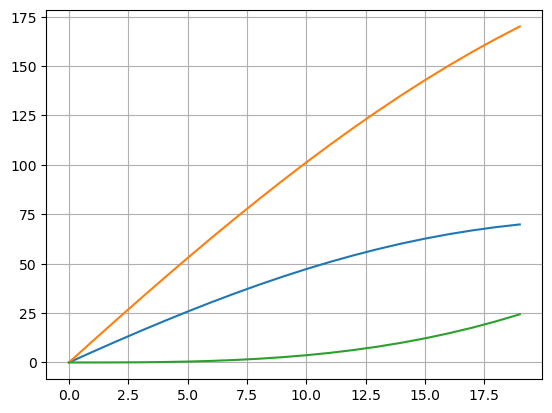

In [5]:
t = cp.random.random(w.shape).astype('float32')
dt0 = cp.random.random(w.shape).astype('float32')/10
phi0 = cp.random.random(1).astype('float32')
dphi0 = cp.random.random(1).astype('float32')/3

l = cp.linspace(0,5,20)
err1 = np.zeros(20)
err2 = np.zeros(20)
err3 = np.zeros(20)
for k in range(20):
    dt = l[k]*dt0
    dphi = l[k]*dphi0
    a = F2([t+dt,phi0+dphi])
    print(cp.linalg.norm(dF2([t,phi0],[dt,0*dphi])),cp.linalg.norm(dF2([t,phi0],[0*dt,dphi])))
    err1[k] = cp.linalg.norm(F2([t,phi0])-a)
    err2[k] = cp.linalg.norm(F2([t,phi0])-dF2([t,phi0],[dt,dphi])-a)    
    err3[k] = cp.linalg.norm(F2([t,phi0])+dF2([t,phi0],[dt,dphi])+0.5*d2F2([t,phi0],[dt,dphi],[dt,dphi])-a)
plt.plot(err1,label='f')
plt.plot(err2,label='linear')
plt.plot(err3,label='quadr')
plt.grid()
plt.show()

# debug plot

In [6]:
def plot_debug(vars, etas, top, bottom, alpha, d, lam):
    """Checking second order approximation"""
    w, phi,a = vars['w'],vars['phi'],vars['a']
    weta, phieta, aeta = etas['w'],etas['phi'],etas['a']
    npp = 9
    errt = cp.zeros(npp * 2)
    errt2 = cp.zeros(npp * 2)
    for k in range(0, npp * 2):
        wt = w + (alpha * k / (npp - 1)) * weta
        phit = phi + (alpha * k / (npp - 1)) * phieta
        at = a + (alpha * k / (npp - 1)) * aeta
        errt[k] = cp.linalg.norm(F1(wt)-d)**2
        errt[k] += lam[0]*cp.linalg.norm(F2([wt,phit]))**2
        errt[k] += lam[1]*(cp.sum((cp.linalg.norm(wt, axis=-1) - at)**2))
        
    t = alpha * (cp.arange(2 * npp)) / (npp - 1)
    errt2 = cp.linalg.norm(F1(w)-d)**2
    errt2 += lam[0]*cp.linalg.norm(F2([w,phi]))**2    
    errt2 += lam[1]*(cp.sum((cp.linalg.norm(w, axis=-1) - a)**2))
    errt2 = errt2 - top * t + 0.5 * bottom * t**2
    print(f'{phi=},{a=}')
    plt.plot(
        (alpha * cp.arange(2 * npp)).get() / (npp - 1),
        errt.get(),
        ".",
        label="real",
    )
    plt.plot(
        (alpha * cp.arange(2 * npp)).get() / (npp - 1),
        errt2.get(),
        ".",
        label="approx",
    )
    plt.legend()
    plt.grid()
    plt.show()

# BH functions

In [7]:

def gradient(vars,lam,d):
    w,phi,a = vars['w'],vars['phi'],vars['a']

    # first part
    gw = 2*F1adj(F1(w)-d) 
    

    # second part
    gw0,gphi = dF2adj([w,phi],2*lam[0]*F2([w,phi]))    
    
    # third part 
    mag = cp.linalg.norm(w, axis=-1) + 1e-7
    
    gw1 = 2*lam[1]*(w - (a * w / mag[..., None]))
    norm_one = cp.float32(cp.size(w[0,...,0]))
    ga = 2*lam[1]*(-cp.sum(mag) + a * norm_one)
        
    # result
    grads = {}
    grads['w'] = gw + gw0 + gw1
    grads['phi'] = gphi
    grads['a'] = ga
    return grads

def hessian_F1(vars,grads,etas):
    dw1 = grads['w']
    dw2 = etas['w']
    
    F1y = F1(dw1)
    F1z = F1(dw2)     
    t1 = 2*cp.real(cp.sum(F1y*cp.conj(F1z)))  
    return t1

def hessian_F2(vars,grads,etas,lam):
    w,phi = vars['w'],vars['phi']
    dw1,dphi1 = grads['w'],grads['phi']
    dw2,dphi2 = etas['w'],etas['phi']
    
    dF21 = dF2([w,phi],[dw1,dphi1])
    dF22 = dF2([w,phi],[dw2,dphi2])
    t1 = 2*cp.real(cp.sum(dF21*cp.conj(dF22)))
    
    d2F = d2F2([w,phi],[dw1,dphi1],[dw2,dphi2])
    t2 = 2*cp.real(cp.sum(F2([w,phi])*cp.conj(d2F)))
    return lam*(t1+t2)

def hessian_F3(vars,grads,etas, lam):    
    w,a = vars['w'],vars['a']
    dw1,da1 = grads['w'],grads['a']
    dw2,da2 = etas['w'],etas['a']

    mag = cp.linalg.norm(w, axis=-1) + cp.float32(1e-7)
    
    w_hat = w / mag[..., None]
    proj1 = cp.sum(w_hat * dw1, axis=-1)
    proj2 = cp.sum(w_hat * dw2, axis=-1)
    scal12 = cp.sum(dw1 * dw2, axis=-1)
    norm_one = cp.float32(cp.size(w[0,...,0]))
    term_da = norm_one * da1 * da2 \
              - cp.sum(w_hat * dw1) * da2 \
              - cp.sum(w_hat * dw2) * da1
    term_w = cp.sum((cp.float32(1.0) - a / mag) * scal12) + cp.sum((a / mag) * (proj1 * proj2))
    return 2 * lam* (term_da + term_w)

def hessian(vars,grads,etas,lam):
    return (hessian_F1(vars,grads,etas)+
            hessian_F2(vars,grads,etas,lam[0])+
            hessian_F3(vars,grads,etas,lam[1]))

def calc_err(vars,lam,d):
    w,phi,a = vars['w'],vars['phi'],vars['a']
    err = (cp.linalg.norm(F1(w)-d)**2+
           lam[0]*cp.linalg.norm(F2([w,phi]))**2+
           lam[1]*(cp.sum((cp.linalg.norm(w, axis=-1) - a)**2)))
    return err

def BH(vars, d, niter,lam):
    err = cp.zeros(niter)
    for i in range(niter):
        
        if i%8==0:
            err[i] = calc_err(vars,lam,d)
            print(i,f'err={err[i]}')
        grads = gradient(vars,lam,d)
        
        if i == 0:
            etas = {}
            etas['w'] = -grads['w']
            etas['phi'] = -grads['phi']
            etas['a'] = -grads['a']
        else:
            top = hessian(vars,grads,etas,lam)
            bottom = hessian(vars,etas,etas,lam)
            beta = top / bottom
            etas['w'] = etas['w'] * beta - grads['w']
            etas['phi'] = etas['phi'] * beta - grads['phi']
            etas['a'] = etas['a'] * beta - grads['a']            
            
        top = (-cp.sum(grads['w']*cp.conj(etas['w'])).real
               -cp.sum(grads['phi']*cp.conj(etas['phi'])).real
               -cp.sum(grads['a']*cp.conj(etas['a'])).real)
        bottom = hessian(vars, etas, etas,lam)
        alpha = top / bottom
        # print(alpha,top,bottom)
        if i%8==0:
            plot_debug(vars,etas,top,bottom,alpha,d,lam)

        vars['w'] += alpha * etas['w']
        vars['phi'] += alpha * etas['phi']
        vars['a'] += alpha * etas['a']       
    return vars,err


0 err=0.92458575963974
phi=np.float32(0.0),a=np.float32(0.0)


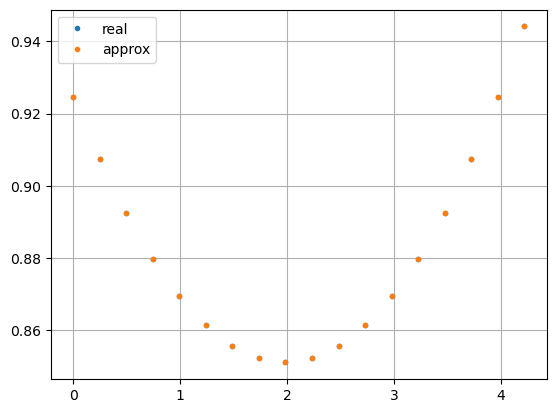

8 err=0.6172248721122742
phi=array(-0.02104749, dtype=float32),a=array(0., dtype=float32)


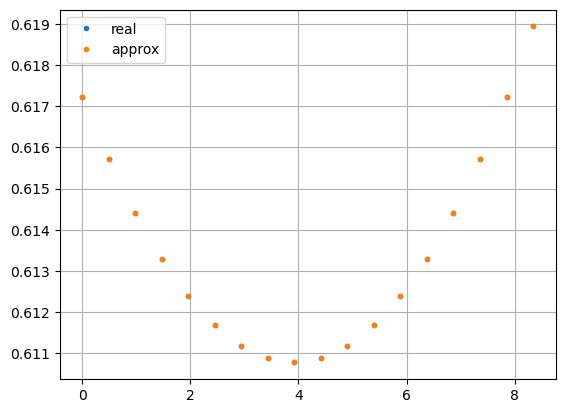

16 err=0.5984904766082764
phi=array(-0.08294383, dtype=float32),a=array(0., dtype=float32)


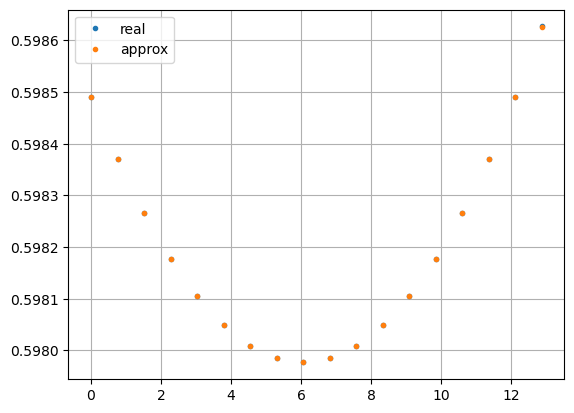

24 err=0.595933735370636
phi=array(-0.18044385, dtype=float32),a=array(0., dtype=float32)


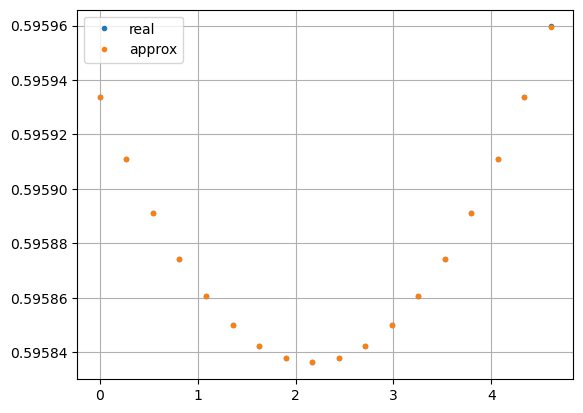

32 err=0.5949982404708862
phi=array(-0.23574497, dtype=float32),a=array(0., dtype=float32)


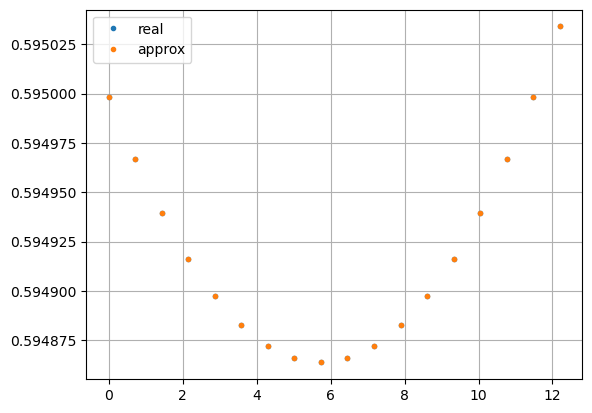

40 err=0.5939608216285706
phi=array(-0.2474645, dtype=float32),a=array(0., dtype=float32)


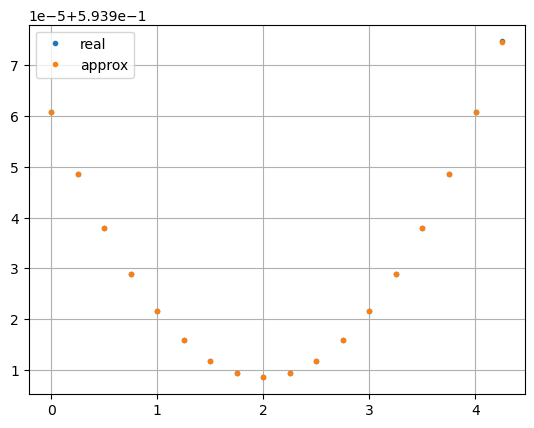

48 err=0.5933722257614136
phi=array(-0.2142858, dtype=float32),a=array(0., dtype=float32)


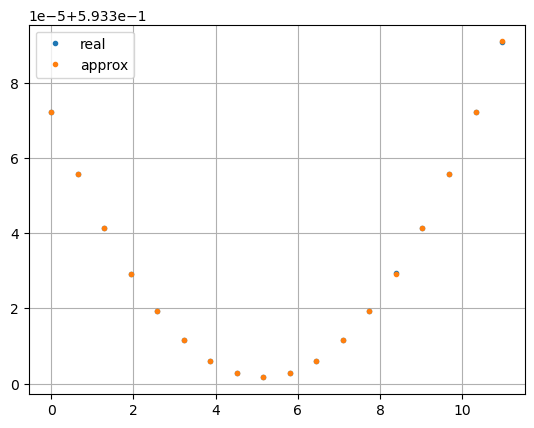

56 err=0.5927594304084778
phi=array(-0.20817229, dtype=float32),a=array(0., dtype=float32)


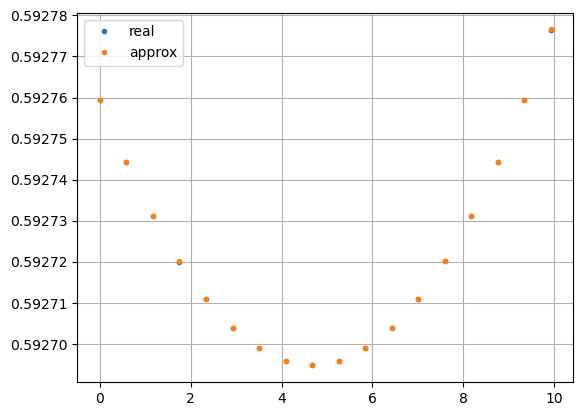

64 err=0.5922918915748596
phi=array(-0.22944133, dtype=float32),a=array(0., dtype=float32)


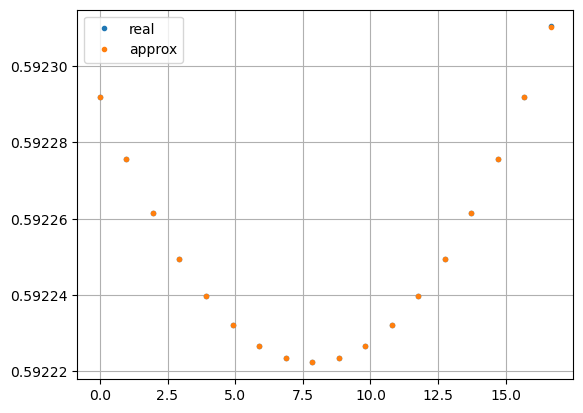

vars['phi']=array(-0.2271019, dtype=float32)


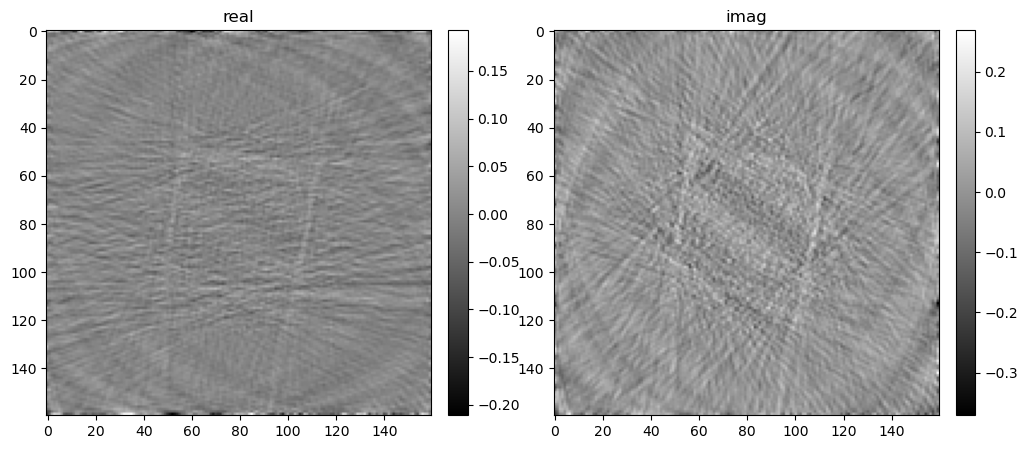

In [11]:
# initial guess
vars = {}
vars['w'] = w*0
vars['phi'] = cp.float32(0)
vars['a'] = cp.float32(0)
lam = [0.0003,0.0]
niter = 65
vars,err2 = BH(vars,data,niter,lam)

print(f'{vars['phi']=}')
mshow_complex(vars['w'][0,:,:,0]+1j*vars['w'][0,:,:,1])

In [9]:
# vars['phi']

In [10]:
# err = cp.zeros(360)
# p = cp.linspace(-cp.pi,cp.pi,360).astype('float32')
# for k in range(360):
#     err[k] = cp.linalg.norm(F2([vars['w'],p[k]]))
#     # mshow(F2([vars['w'],vars['phi']])[80])
#     # mshow((F1(vars['w'])-data)[:,80])
#     # mshow(data[:,80])
# plt.plot(p.get(),err)
# plt.plot(vars['phi'].get(),cp.linalg.norm(F2([vars['w'],vars['phi']])).get(),'rx')

